# Required

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import zipfile
import numpy as np
from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split

import torch.optim as optim
from torch.optim import SGD
from tqdm import tqdm
import torchvision.transforms as T

import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CocoDetection
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou

In [3]:
# Set paths for dataset
data_dir = '/content/drive/MyDrive/ColabNotebooks/'
train_zip = os.path.join(data_dir, 'TrainIJCNN2013.zip')
test_zip = os.path.join(data_dir, 'TestIJCNN2013.zip')
annotations_file = '/content/drive/MyDrive/ColabNotebooks/gt.txt'

In [4]:
# -*- coding: utf-8 -*-
"""GTSDB_Faster_RCNN.ipynb"""

# Import necessary libraries
import os
import zipfile
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


# Extract the dataset
train_dir = '/content/train/TrainIJCNN2013'
test_dir = '/content/test/TestIJCNN2013Download'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

with zipfile.ZipFile(train_zip, 'r') as zip_ref:
    zip_ref.extractall('/content')
with zipfile.ZipFile(test_zip, 'r') as zip_ref:
    zip_ref.extractall('/content')

print("Dataset extracted successfully.")
train_dir = '/content/train/TrainIJCNN2013/TrainIJCNN2013'
test_dir = '/content/test/TestIJCNN2013Download/TestIJCNN2013Download'


Dataset extracted successfully.


In [5]:
import shutil

train_dir = 'TrainIJCNN2013'
test_dir = 'TestIJCNN2013Download'
shutil.copy(annotations_file, train_dir)
annotations_file = "/content/TrainIJCNN2013/gt.txt"

In [6]:
# Λίστα για αποθήκευση διαστάσεων
image_dimensions = []

# Διαπέραση όλων των αρχείων στον φάκελο
for filename in os.listdir(train_dir):
    if filename.endswith(".ppm"):  # Έλεγχος για αρχεία .ppm
        file_path = os.path.join(train_dir, filename)
        with Image.open(file_path) as img:
            width, height = img.size  # Απόκτηση πλάτους και ύψους
            image_dimensions.append((filename, width, height))
            print(f"Image: {filename}, Width: {width}, Height: {height}")

# Ανάλυση των αποτελεσμάτων
print(f"\nTotal images: {len(image_dimensions)}")
print(f"Example dimensions: {image_dimensions[:5]}")

Image: 00458.ppm, Width: 1360, Height: 800
Image: 00177.ppm, Width: 1360, Height: 800
Image: 00262.ppm, Width: 1360, Height: 800
Image: 00479.ppm, Width: 1360, Height: 800
Image: 00059.ppm, Width: 1360, Height: 800
Image: 00179.ppm, Width: 1360, Height: 800
Image: 00057.ppm, Width: 1360, Height: 800
Image: 00348.ppm, Width: 1360, Height: 800
Image: 00213.ppm, Width: 1360, Height: 800
Image: 00031.ppm, Width: 1360, Height: 800
Image: 00289.ppm, Width: 1360, Height: 800
Image: 00559.ppm, Width: 1360, Height: 800
Image: 00488.ppm, Width: 1360, Height: 800
Image: 00011.ppm, Width: 1360, Height: 800
Image: 00246.ppm, Width: 1360, Height: 800
Image: 00411.ppm, Width: 1360, Height: 800
Image: 00504.ppm, Width: 1360, Height: 800
Image: 00548.ppm, Width: 1360, Height: 800
Image: 00454.ppm, Width: 1360, Height: 800
Image: 00137.ppm, Width: 1360, Height: 800
Image: 00343.ppm, Width: 1360, Height: 800
Image: 00406.ppm, Width: 1360, Height: 800
Image: 00172.ppm, Width: 1360, Height: 800
Image: 0031

In [7]:
import torch
import os

def parse_annotations(annotations_file, image_dir):
    annotations = []

    # Φόρτωση των annotations
    with open(annotations_file, "r") as f:
        for line_no, line in enumerate(f.readlines()):
            if line_no == 0:  # Παράλειψη της γραμμής επικεφαλίδας
                continue
            fields = line.strip().split(",")
            if len(fields) != 6:  # Αναμενόμενες στήλες: filename, x1, y1, x2, y2, class
                print(f"Skipping malformed line {line_no + 1}: {line.strip()}")
                continue
            filename, x1, y1, x2, y2, class_id = fields
            x1, y1, x2, y2 = float(x1), float(y1), float(x2), float(y2)
            class_id = int(class_id)
            # Έλεγχος για bounding boxes εκτός ορίων εικόνας
            if x1 < 0 or y1 < 0 or x2 > 2048 or y2 > 2048:
                print(f"Skipping bounding box out of bounds: {filename}, [{x1}, {y1}, {x2}, {y2}]")
                continue
            # Έλεγχος για μη έγκυρα bounding boxes
            if x1 >= x2 or y1 >= y2:
                print(f"Skipping invalid bounding box at line {line_no + 1}: [{x1}, {y1}, {x2}, {y2}]")
                continue
            # Έλεγχος για πολύ μικρά bounding boxes
            if abs(x2 - x1) < 10 or abs(y2 - y1) < 10:
                print(f"Skipping small bounding box at line {line_no + 1}: [{x1}, {y1}, {x2}, {y2}]")
                continue
            # Προσθήκη στα annotations
            annotations.append({
                "filename": filename,
                "bbox": [x1, y1, x2, y2],
                "label": class_id
            })

    return annotations
    return annotations


# Example usage
annotations = parse_annotations(annotations_file, train_dir)

# Check the first few annotations to verify the format
print(annotations[:5])
annotations = parse_annotations(annotations_file, train_dir)
print(f"Parsed Annotations: {annotations[:5]}")  # Εμφάνιση των πρώτων 5 γραμμών
print(f"Total annotations: {len(annotations)}")

[{'filename': '/content/TrainIJCNN2013/00000.ppm', 'bbox': [774.0, 411.0, 815.0, 446.0], 'label': 11}, {'filename': '/content/TrainIJCNN2013/00001.ppm', 'bbox': [983.0, 388.0, 1024.0, 432.0], 'label': 40}, {'filename': '/content/TrainIJCNN2013/00001.ppm', 'bbox': [386.0, 494.0, 442.0, 552.0], 'label': 38}, {'filename': '/content/TrainIJCNN2013/00001.ppm', 'bbox': [973.0, 335.0, 1031.0, 390.0], 'label': 13}, {'filename': '/content/TrainIJCNN2013/00002.ppm', 'bbox': [892.0, 476.0, 1006.0, 592.0], 'label': 39}]
Parsed Annotations: [{'filename': '/content/TrainIJCNN2013/00000.ppm', 'bbox': [774.0, 411.0, 815.0, 446.0], 'label': 11}, {'filename': '/content/TrainIJCNN2013/00001.ppm', 'bbox': [983.0, 388.0, 1024.0, 432.0], 'label': 40}, {'filename': '/content/TrainIJCNN2013/00001.ppm', 'bbox': [386.0, 494.0, 442.0, 552.0], 'label': 38}, {'filename': '/content/TrainIJCNN2013/00001.ppm', 'bbox': [973.0, 335.0, 1031.0, 390.0], 'label': 13}, {'filename': '/content/TrainIJCNN2013/00002.ppm', 'bbox

In [8]:
# Define the dataset class for GTSDB
class GTSDBDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, annotations_file, transforms=None):
        self.image_dir = image_dir
        self.transforms = transforms
        self.annotations = parse_annotations(annotations_file, image_dir)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        img_path = os.path.join(self.image_dir, annotation["filename"])
        img = Image.open(img_path).convert("RGB")

        # Convert bounding boxes and labels to tensors
        bbox = torch.tensor([annotation["bbox"]], dtype=torch.float32)  # (num_boxes, 4)
        label = torch.tensor([annotation["label"]], dtype=torch.int64)  # (num_boxes,)

        target = {"boxes": bbox, "labels": label}

        # Apply transformations if any
        if self.transforms:
            img = self.transforms(img)

        return img, target

In [9]:
# Define transforms for the dataset
transforms = T.Compose([
    T.ToTensor(),  # Convert image to tensor
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Imagenet normalization
])

# Load the dataset
train_dataset = GTSDBDataset(train_dir, annotations_file, transforms=transforms)
test_dataset = GTSDBDataset(test_dir, annotations_file, transforms=transforms)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Faster-RCNN

In [10]:
# Define Faster R-CNN model
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision

def get_faster_rcnn_model(num_classes):
    """
    Load Faster R-CNN with a ResNet50 backbone and modify it for GTSDB.
    """
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Replace the classifier with one for our dataset
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Initialize the model
num_classes = 43  # 42 traffic sign classes + 1 background
model = get_faster_rcnn_model(num_classes)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 240MB/s]


In [11]:
from sklearn.metrics import precision_score, recall_score
import numpy as np

def evaluate_precision_recall(model, dataloader, device, confidence_threshold=0.1):
    model.eval()  # Set model to evaluation mode
    all_true_labels = []
    all_pred_labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                true_boxes = targets[i]["boxes"].cpu().numpy()
                true_labels = targets[i]["labels"].cpu().numpy()

                pred_boxes = output["boxes"].cpu().numpy()
                pred_scores = output["scores"].cpu().numpy()
                pred_labels = output["labels"].cpu().numpy()

                # Filter predictions based on confidence threshold
                mask = pred_scores >= confidence_threshold
                pred_boxes = pred_boxes[mask]
                pred_labels = pred_labels[mask]

                # Append the ground truth and predicted labels
                all_true_labels.extend(true_labels)
                all_pred_labels.extend(pred_labels)

    # Convert to numpy arrays for evaluation
    all_true_labels = np.array(all_true_labels)
    all_pred_labels = np.array(all_pred_labels)

    # Compute precision and recall
    precision = precision_score(all_true_labels, all_pred_labels, average='weighted', zero_division=1)
    recall = recall_score(all_true_labels, all_pred_labels, average='weighted', zero_division=1)

    return precision, recall


In [12]:
import os
import torch
from tqdm import tqdm

checkpoint_path = "/content/drive/MyDrive/ColabNotebooks/checkpoint.pth"
best_model_path = "/content/drive/MyDrive/ColabNotebooks/checkpoints_drive/best_model.pth"

# Training loop with model saving after each epoch and loss calculation
def train_model(model, train_loader, device, optimizer, num_epochs=10, checkpoint_dir='checkpoints'):
    model.train()
    best_loss = float('inf')
    best_epoch = 0

    # Αν υπάρχει ήδη ένα best_model.pth, φόρτωσέ το και ενημέρωσε το best_loss
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)

        best_loss = checkpoint.get('best_loss', float('inf'))
        print(f"Loaded existing best model with loss: {best_loss:.4f}")

        # Φόρτωση των weights του μοντέλου
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        best_epoch = checkpoint.get("epoch", 0)

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    for epoch in range(best_epoch, best_epoch + num_epochs):  # Συνεχίζουμε από το σωστό epoch
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        total_loss = 0

        for images, targets in pbar:
            torch.cuda.empty_cache()  # Καθαρίζει τη μνήμη GPU πριν από κάθε batch

            # Move images and targets to device
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass and compute loss
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            total_loss += loss.item()

            # Backward pass and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Ενημέρωση της γραμμής προόδου
            pbar.set_postfix(loss=loss.item())

        # Calculate average loss for the epoch
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")

        # Save the model after every epoch if loss is improving
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_epoch = epoch + 1  # Store best epoch
            model_save_path = os.path.join(checkpoint_dir, f"model_epoch_{best_epoch}_loss_{avg_loss:.4f}.pth")
            torch.save(model.state_dict(), model_save_path)
            print(f"New best model saved at epoch {best_epoch} with avg_loss {best_loss:.4f}")

    # Final model saving after all epochs
    final_model_path = os.path.join(checkpoint_dir, "best_model.pth")
    torch.save({
        'epoch': best_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_loss': best_loss
    }, best_model_path)
    print(f"Best model saved after epoch {best_epoch} with loss {best_loss:.4f}")

    # Αποθήκευση checkpoint στο Google Drive
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': best_epoch,
        'best_loss': best_loss
    }, checkpoint_path)

    print(f"Checkpoint saved to {checkpoint_path}")

In [13]:
torch.cuda.empty_cache()
train_model(model, train_loader, device, optimizer, num_epochs=10, checkpoint_dir='checkpoints')

Epoch 1/10: 100%|██████████| 107/107 [04:13<00:00,  2.37s/it, loss=0.35]


Epoch 1, Average Loss: 0.5403
New best model saved at epoch 1 with avg_loss 0.5403


Epoch 2/10: 100%|██████████| 107/107 [04:15<00:00,  2.39s/it, loss=0.209]


Epoch 2, Average Loss: 0.2480
New best model saved at epoch 2 with avg_loss 0.2480


Epoch 3/10: 100%|██████████| 107/107 [04:14<00:00,  2.38s/it, loss=0.248]


Epoch 3, Average Loss: 0.2037
New best model saved at epoch 3 with avg_loss 0.2037


Epoch 4/10: 100%|██████████| 107/107 [04:14<00:00,  2.37s/it, loss=0.155]


Epoch 4, Average Loss: 0.1796
New best model saved at epoch 4 with avg_loss 0.1796


Epoch 5/10: 100%|██████████| 107/107 [04:14<00:00,  2.38s/it, loss=0.144]


Epoch 5, Average Loss: 0.1663
New best model saved at epoch 5 with avg_loss 0.1663


Epoch 6/10: 100%|██████████| 107/107 [04:14<00:00,  2.37s/it, loss=0.112]


Epoch 6, Average Loss: 0.1652
New best model saved at epoch 6 with avg_loss 0.1652


Epoch 7/10: 100%|██████████| 107/107 [04:13<00:00,  2.37s/it, loss=0.164]


Epoch 7, Average Loss: 0.1684


Epoch 8/10: 100%|██████████| 107/107 [04:14<00:00,  2.38s/it, loss=0.202]


Epoch 8, Average Loss: 0.1803


Epoch 9/10: 100%|██████████| 107/107 [04:14<00:00,  2.38s/it, loss=0.222]


Epoch 9, Average Loss: 0.1718


Epoch 10/10: 100%|██████████| 107/107 [04:13<00:00,  2.37s/it, loss=0.135]


Epoch 10, Average Loss: 0.1604
New best model saved at epoch 10 with avg_loss 0.1604
Best model saved after epoch 10 with loss 0.1604
Checkpoint saved to /content/drive/MyDrive/ColabNotebooks/checkpoint.pth


In [ ]:
import torch
import torchvision.transforms as T
import torchvision.models as models
from PIL import Image
import numpy as np

# Φόρτωση του ResNet50 για Classification
resnet50_model_path = "/content/drive/MyDrive/ColabNotebooks/resnet50_best.pth"

# Φόρτωση του ResNet50 και προσαρμογή για 43 classes
resnet50 = models.resnet50(pretrained=False)
num_ftrs = resnet50.fc.in_features
resnet50.fc = torch.nn.Linear(num_ftrs, 43)  # 43 κατηγορίες πινακίδων

# Φόρτωση των βαρών
resnet50.load_state_dict(torch.load(resnet50_model_path, map_location="cuda" if torch.cuda.is_available() else "cpu"))
resnet50.eval()
resnet50.to("cuda" if torch.cuda.is_available() else "cpu")

# Μετασχηματισμοί εικόνας για ResNet50
resnet_transform = T.Compose([
    T.Resize((224, 224)),  # Resize στο input του ResNet50
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def detect_and_classify(model, image_path, device):
    """
    1. Χρησιμοποιεί το Faster R-CNN για Object Detection
    2. Κόβει τις ανιχνευμένες περιοχές (ROIs)
    3. Χρησιμοποιεί το ResNet50 για Classification
    """
    model.eval()  # Faster R-CNN σε eval mode

    # Φόρτωση και μετατροπή εικόνας για το Faster R-CNN
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([T.ToTensor()])
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Ανίχνευση αντικειμένων με Faster R-CNN
    with torch.no_grad():
        predictions = model(image_tensor)[0]

    detected_boxes = predictions["boxes"].cpu().numpy()
    detected_scores = predictions["scores"].cpu().numpy()
    detected_labels = predictions["labels"].cpu().numpy()

    # Threshold για αποδοχή αντικειμένων
    threshold = 0.5
    valid_indices = detected_scores > threshold

    final_boxes = detected_boxes[valid_indices]
    final_labels = detected_labels[valid_indices]

    # Χρήση ResNet50 για ταξινόμηση των ανιχνευμένων περιοχών
    classifications = []
    for box in final_boxes:
        x_min, y_min, x_max, y_max = map(int, box)

        # Κόψιμο της περιοχής από την εικόνα
        roi = image.crop((x_min, y_min, x_max, y_max))

        # Μετατροπή για ResNet50
        roi_tensor = resnet_transform(roi).unsqueeze(0).to(device)

        # Ταξινόμηση με ResNet50
        with torch.no_grad():
            outputs = resnet50(roi_tensor)
            predicted_class = torch.argmax(outputs, dim=1).item()

        classifications.append((box, predicted_class))

    return classifications  # Επιστρέφει τα ROIs με τις κλάσεις τους

In [ ]:
# Φόρτωση του εκπαιδευμένου Faster R-CNN
faster_rcnn_model_path = "/content/drive/MyDrive/ColabNotebooks/checkpoints_drive/best_model.pth"
faster_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=43)
faster_rcnn.load_state_dict(torch.load(faster_rcnn_model_path, map_location="cuda"))
faster_rcnn.to("cuda" if torch.cuda.is_available() else "cpu")

# Δοκιμή της detect_and_classify σε νέα εικόνα
image_path = "/content/traffic_sign.jpg"
results = detect_and_classify(faster_rcnn, image_path, "cuda")

# Εκτύπωση αποτελεσμάτων
for bbox, cls in results:
    print(f"Detected Box: {bbox}, Classified as: {cls}")

# ResNet50 Classification

In [10]:
!pip install -q tf2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 16.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.1 requires protobuf<6.0.0dev,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.


In [11]:
!pip install onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 109.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.1 MB/s eta 0:00:00


In [12]:
import onnxruntime

# 1. Ορισμός του ONNX μοντέλου
onnx_model_path = "/content/drive/MyDrive/ColabNotebooks/resnet50.onnx"

In [29]:
# 2. Φόρτωση του ONNX μοντέλου μέσω onnxruntime
session = onnxruntime.InferenceSession(onnx_model_path)

# Ονόματα των εισόδων και εξόδων του ONNX μοντέλου
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

In [13]:
import onnx
import onnxruntime
import torch
import torchvision.models as models
import torch.onnx

# Φόρτωση του ONNX μοντέλου
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)

# Δημιουργία PyTorch ResNet50
resnet50_pytorch = models.resnet50(weights=None)
num_ftrs = resnet50_pytorch.fc.in_features
resnet50_pytorch.fc = torch.nn.Linear(num_ftrs, 43)  # 43 classes για τις πινακίδες

# Μετατροπή του ONNX output σε PyTorch format
ort_session = onnxruntime.InferenceSession(onnx_model_path)

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

dummy_input = torch.randn(1, 224, 224, 3)
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(dummy_input)}
ort_outs = ort_session.run(None, ort_inputs)

# Αποθήκευση του PyTorch ResNet50
torch.save(resnet50_pytorch.state_dict(), "/content/drive/MyDrive/ColabNotebooks/resnet50_best.pth")
print("ResNet50 successfully converted to PyTorch!")

ResNet50 successfully converted to PyTorch!


In [38]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.rpn import AnchorGenerator

# Ορισμός της συσκευής (CPU / GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ορισμός του CUDA Allocation για αποφυγή Fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Φόρτωση του αποθηκευμένου ResNet50 (χωρίς Fully Connected layers)
resnet50_model_path = "/content/drive/MyDrive/ColabNotebooks/resnet50_best.pth"
state_dict = torch.load(resnet50_model_path, map_location=device, weights_only=True)

# Δημιουργία του ResNet50 Backbone με FPN
backbone = resnet_fpn_backbone('resnet50', weights=None)
backbone.load_state_dict(state_dict, strict=False)  # Φορτώνουμε τα βάρη

# ΔΙΟΡΘΩΣΗ: Ορισμός `AnchorGenerator` για 5 feature maps
anchor_generator = AnchorGenerator(
    sizes=((16,), (32,), (64,), (128,), (256,)),
    aspect_ratios=((0.5, 1.0, 2.0),) * 5
)

# Ορισμός του Faster R-CNN με το ResNet50 backbone και το ROI Head
model = FasterRCNN(
    backbone,
    num_classes=43,  # 42 κλάσεις + background
    rpn_anchor_generator=anchor_generator
)

# Αντικατάσταση του ROI Head με `FastRCNNPredictor`
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=43)

# Mixed Precision Training (μείωση κατανάλωσης RAM)
scaler = torch.cuda.amp.GradScaler()

# Μεταφορά στη GPU
model.to(device)
torch.cuda.empty_cache()  # Αποδέσμευση RAM

print("Faster R-CNN with ResNet50 backbone is ready!")

# Χρήση gradient checkpointing (εξοικονόμηση μνήμης)
model.backbone.requires_grad_(False)  # Δεν εκπαιδεύουμε όλο το backbone
for param in model.backbone.parameters():
    param.requires_grad = False  # Κλείδωμα gradients για backbone

# Βελτιστοποιητής
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

<ipython-input-38-be8b48e6119b>:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Faster R-CNN with ResNet50 backbone is ready!


In [ ]:
# Φόρτωση του εκπαιδευμένου ResNet50 για classification
resnet50_model_path = "/content/drive/MyDrive/ColabNotebooks/resnet50_best.pth"

# Φτιάχνουμε το ResNet50 για ταξινόμηση σε 43 κλάσεις
resnet50 = torchvision.models.resnet50(weights=None)  # Χωρίς default βάρη
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, num_classes)  # 43 κλάσεις

# Φόρτωση των βαρών του μοντέλου
resnet50.load_state_dict(torch.load(resnet50_model_path, map_location=device))

# Μεταφορά του ResNet50 στη συσκευή
resnet50.to(device)
resnet50.eval()

In [12]:
import os
import torch
from tqdm import tqdm

checkpoint_path = "/content/drive/MyDrive/ColabNotebooks/checkpoint.pth"
best_model_path = "/content/drive/MyDrive/ColabNotebooks/checkpoints_drive/best_model.pth"

# Training loop with model saving after each epoch and loss calculation
def train_model(model, train_loader, device, optimizer, num_epochs=10, checkpoint_dir='checkpoints'):
    model.train()
    best_loss = float('inf')
    best_epoch = 0

    # Αν υπάρχει ήδη ένα best_model.pth, φόρτωσέ το και ενημέρωσε το best_loss
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)

        best_loss = checkpoint.get('best_loss', float('inf'))
        print(f"Loaded existing best model with loss: {best_loss:.4f}")

        # Φόρτωση των weights του μοντέλου
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        best_epoch = checkpoint.get("epoch", 0)

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    for epoch in range(best_epoch, best_epoch + num_epochs):  # Συνεχίζουμε από το σωστό epoch
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        total_loss = 0

        for images, targets in pbar:
            torch.cuda.empty_cache()  # Καθαρίζει τη μνήμη GPU πριν από κάθε batch

            # Move images and targets to device
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass and compute loss
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            total_loss += loss.item()

            # Backward pass and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Ενημέρωση της γραμμής προόδου
            pbar.set_postfix(loss=loss.item())

        # Calculate average loss for the epoch
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")

        # Save the model after every epoch if loss is improving
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_epoch = epoch + 1  # Store best epoch
            model_save_path = os.path.join(checkpoint_dir, f"model_epoch_{best_epoch}_loss_{avg_loss:.4f}.pth")
            torch.save(model.state_dict(), model_save_path)
            print(f"New best model saved at epoch {best_epoch} with avg_loss {best_loss:.4f}")

    # Final model saving after all epochs
    final_model_path = os.path.join(checkpoint_dir, "best_model.pth")
    torch.save({
        'epoch': best_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_loss': best_loss
    }, best_model_path)
    print(f"Best model saved after epoch {best_epoch} with loss {best_loss:.4f}")

    # Αποθήκευση checkpoint στο Google Drive
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': best_epoch,
        'best_loss': best_loss
    }, checkpoint_path)

    print(f"Checkpoint saved to {checkpoint_path}")

In [20]:
import shutil
import os

checkpoint_path = '/content/checkpoints'
destination_dir = '/content/drive/MyDrive/ColabNotebooks/checkpoints_drive'

if os.path.exists(destination_dir):
    shutil.rmtree(destination_dir)  # Διαγραφή του φακέλου

# Αντιγραφή ολόκληρου του φακέλου από το checkpoint_path στο destination_dir
shutil.copytree(checkpoint_path, destination_dir)

print(f"Folder copied from {checkpoint_path} to {destination_dir}")


Folder copied from /content/checkpoints to /content/drive/MyDrive/ColabNotebooks/checkpoints_drive


# Checkpoint

In [33]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# 1. Καθορισμός της συσκευής
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Αρχικοποίηση του μοντέλου
num_classes = 43  # 42 κατηγορίες + background
model = fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

<ipython-input-33-92dd04830811>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/checkpoints/model_epoch_22_loss_0.0828.pth"))


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
# 3. Φόρτωση των weights
#model.load_state_dict(torch.load("/content/drive/MyDrive/ColabNotebooks/checkpoints_drive/best_model.pth"))
model.load_state_dict(torch.load("/content/checkpoints/model_epoch_22_loss_0.0828.pth"))

# 4. Μεταφορά του μοντέλου στη συσκευή
model.to(device)
model.eval()  # Set to evaluation mode

#print(f"Checkpoint loaded. Resuming from epoch {start_epoch} with best loss {best_loss}")

In [ ]:
# 5. Inference Loop
with torch.no_grad():
    for images, targets in test_loader:
        # Μεταφορά των εικόνων στη συσκευή
        images = [img.to(device) for img in images]

        # Εκτέλεση προβλέψεων
        predictions = model(images)

        for i, prediction in enumerate(predictions):
            print(f"Prediction {i}:")
            print(f"Boxes: {prediction['boxes']}")
            print(f"Labels: {prediction['labels']}")
            print(f"Scores: {prediction['scores']}")

In [31]:
def evaluate_precision_recall(model, dataloader, device):
    """
    Evaluation function που τρέχει το Faster R-CNN και χρησιμοποιεί
    το ONNX ResNet50 για ταξινόμηση των ανιχνευμένων πινακίδων.
    """
    model.eval()
    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            detections = model(images)  # Faster R-CNN Inference

            for img_idx, detection in enumerate(detections):
                print(f"======== Processing Image {img_idx + 1} ========")

                # Περνάμε κάθε ανιχνευμένη περιοχή στο ResNet50 ONNX
                for i, box in enumerate(detection["boxes"]):
                    x1, y1, x2, y2 = box.int().tolist()

                    # Crop του detected object
                    roi = images[img_idx][:, y1:y2, x1:x2]

                    # Μετατροπή σε NumPy και ResNet50 preprocessing
                    roi = roi.permute(1, 2, 0).cpu().numpy()
                    roi = Image.fromarray((roi * 255).astype(np.uint8))

                    # **ΔΙΟΡΘΩΣΗ: Resize σε 224x224 και σωστή διάταξη καναλιών**
                    roi = roi.resize((224, 224))
                    roi = transforms(roi)
                    roi = roi.permute(1, 2, 0).numpy()  # Μετατροπή από (H, W, C) σε (C, H, W)
                    roi = np.expand_dims(roi, axis=0)   # Προσθήκη batch dimension

                    # Ταξινόμηση με το ONNX ResNet50
                    prediction = session.run([output_name], {input_name: roi})
                    predicted_class = np.argmax(prediction)

                    print(f"Traffic sign classified as: {predicted_class}")

In [ ]:
print("Evaluating the trained Faster R-CNN with ONNX ResNet50 classification...")
evaluate_precision_recall(model, test_loader, device)

# Visualize Predictions (w/o loaded model)

In [25]:
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Map class IDs to class names
CLASS_ID_TO_INT = {i: i for i in range(42)}  # 42 κατηγορίες
CLASS_ID_TO_INT[0] = 0  # Το background

def visualize_predictions(image_path, model, threshold=0.1):
    """
    Visualize predictions on a single image.

    Args:
    - image_path: Path to the input image.
    - model: Trained Faster R-CNN model.
    - threshold: Confidence threshold for displaying predictions.
    """
    # Load and preprocess the image
    img = Image.open(image_path).convert("RGB")
    transform = T.Compose([T.ToTensor()])
    img_tensor = transform(img).to(device)

    # Make predictions
    with torch.no_grad():
        prediction = model([img_tensor])

    # Extract boxes, labels, and scores
    pred_boxes = prediction[0]['boxes'].cpu().numpy()
    pred_scores = prediction[0]['scores'].cpu().numpy()
    pred_labels = prediction[0]['labels'].cpu().numpy()

    # Draw boxes on the original image
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
        if score >= threshold:
            x1, y1, x2, y2 = box.astype(int)
            class_name = CLASS_ID_TO_INT[label]

            # Draw rectangle and label
            cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img_cv, f"{class_name}: {score:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


Visualizing predictions for: 00177.ppm


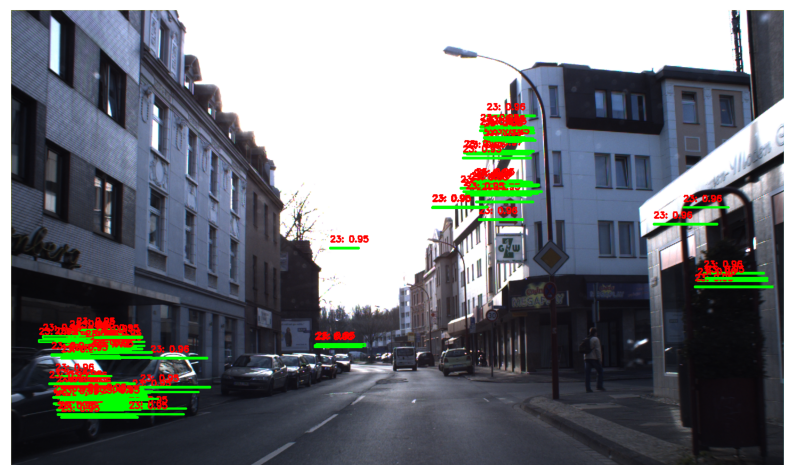

Visualizing predictions for: 00262.ppm


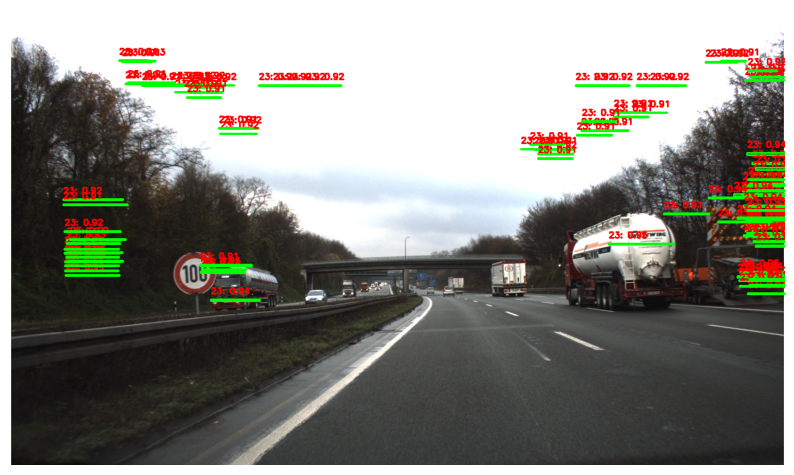

Visualizing predictions for: 00059.ppm


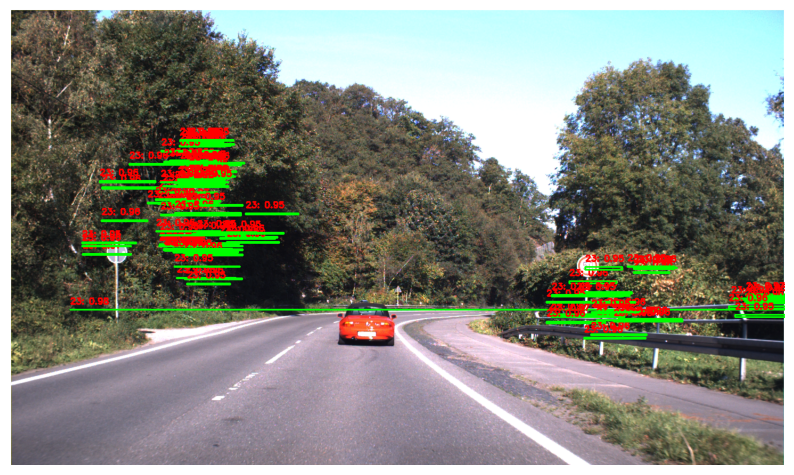

Visualizing predictions for: 00179.ppm


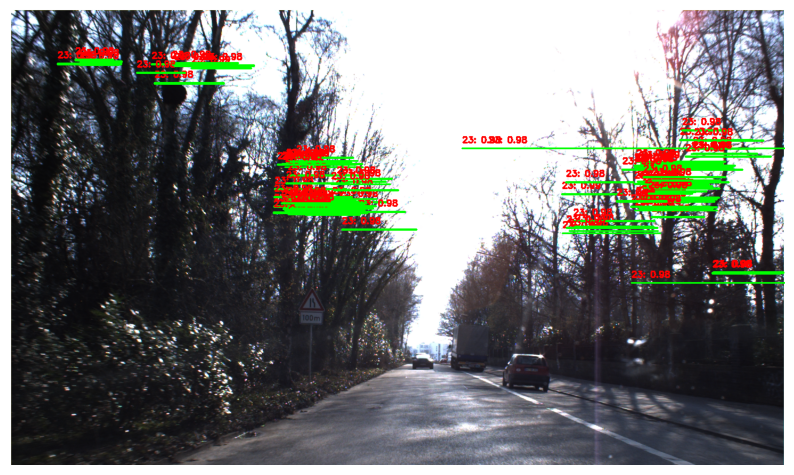

Visualizing predictions for: 00057.ppm


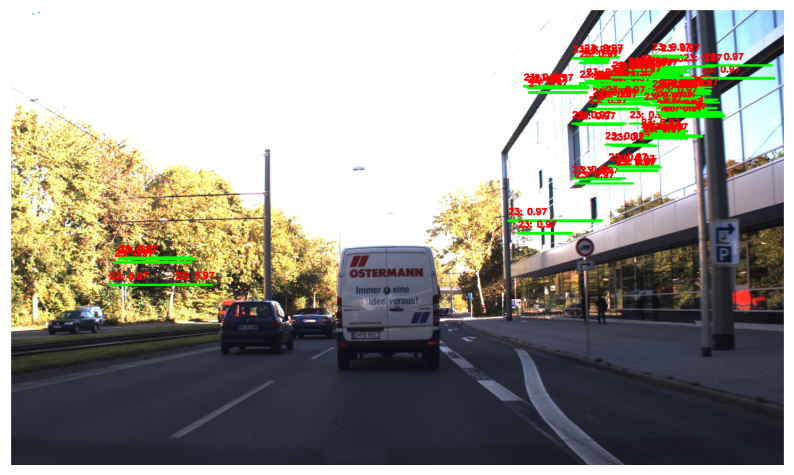

In [26]:
import os
import numpy as np
# Test images directory
test_images_dir = 'TestIJCNN2013Download'
os.makedirs(test_images_dir, exist_ok=True)

# List all test images
test_images = os.listdir(test_images_dir)

# Visualize predictions for a few images
for i in range(5):  # Visualize first 5 images
    image_path = os.path.join(test_images_dir, test_images[i])
    print(f"Visualizing predictions for: {test_images[i]}")
    visualize_predictions(image_path, model, threshold=0.2)

# Visualize Predictions with ResNet50

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision.models as models
from PIL import Image
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Φόρτωση του εκπαιδευμένου ResNet50 για Classification
resnet50_path = "/content/drive/MyDrive/ColabNotebooks/resnet50_best.pth"
resnet50 = models.resnet50(pretrained=False)
num_ftrs = resnet50.fc.in_features
resnet50.fc = torch.nn.Linear(num_ftrs, 42)  # 42 κλάσεις για τις πινακίδες
resnet50.load_state_dict(torch.load(resnet50_path, map_location=device))
resnet50.to(device)
resnet50.eval()  # Set model to evaluation mode

# Map class IDs to class names
CLASS_ID_TO_INT = {i: i for i in range(42)}  # 42 κατηγορίες
CLASS_ID_TO_INT[0] = 0  # Background

# Μετατροπές για την εικόνα
transform = T.Compose([
    T.Resize((224, 224)),  # Resize στο input του ResNet50
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def visualize_predictions(image_path, faster_rcnn, resnet50, threshold=0.5):
    """
    1. Ανιχνεύει περιοχές με Faster R-CNN.
    2. Κόβει τις περιοχές και τις ταξινομεί με ResNet50.
    3. Εμφανίζει τις ταξινομημένες πινακίδες στην εικόνα.

    Args:
    - image_path: Path της εισόδου εικόνας.
    - faster_rcnn: Trained Faster R-CNN για object detection.
    - resnet50: Trained ResNet50 για classification.
    - threshold: Confidence threshold για προβολή των ανιχνεύσεων.
    """

    # Φόρτωση εικόνας
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).to(device)

    # Ανίχνευση περιοχών με Faster R-CNN
    with torch.no_grad():
        predictions = faster_rcnn([img_tensor])

    # Εξαγωγή bounding boxes, scores και labels
    pred_boxes = predictions[0]['boxes'].cpu().numpy()
    pred_scores = predictions[0]['scores'].cpu().numpy()

    # Αντιγραφή της αρχικής εικόνας
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    for box, score in zip(pred_boxes, pred_scores):
        if score >= threshold:
            x1, y1, x2, y2 = box.astype(int)

            # **Κόψε το ROI από την εικόνα**
            roi = img.crop((x1, y1, x2, y2))  # Crop using PIL

            # **Μετατροπή του ROI για το ResNet50**
            roi_tensor = transform(roi).unsqueeze(0).to(device)

            # **Πρόβλεψη της κατηγορίας με ResNet50**
            with torch.no_grad():
                class_probs = resnet50(roi_tensor)
                predicted_class = torch.argmax(class_probs, dim=1).item()

            # **Σχεδίαση του bounding box και της πρόβλεψης**
            class_name = CLASS_ID_TO_INT.get(predicted_class, "Unknown")
            cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img_cv, f"{class_name}: {score:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Εμφάνιση εικόνας
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

In [ ]:
import os
import numpy as np
# Test images directory
test_images_dir = 'TestIJCNN2013Download'
os.makedirs(test_images_dir, exist_ok=True)

# List all test images
test_images = os.listdir(test_images_dir)

offset = 150
# Visualize predictions for a few images
for i in range(10):  # Visualize first 10 images
    image_path = os.path.join(test_images_dir, test_images[i+offset])
    print(f"Visualizing predictions for: {test_images[i+offset]}")
    visualize_predictions(image_path, model, resnet50, threshold=0.15)

In [27]:
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as T
import numpy as np
import torch
from PIL import Image

# Map class IDs to class names
CLASS_ID_TO_INT = {i: i for i in range(42)}  # 42 κατηγορίες
CLASS_ID_TO_INT[0] = 0  # Το background

def visualize_predictions(image_path, model, session, transform, input_name, output_name, threshold=0.15):
    """
    Visualize predictions on a single image with Faster R-CNN (Detection) and ONNX ResNet50 (Classification).

    Args:
    - image_path: Path to the input image.
    - model: Trained Faster R-CNN model.
    - session: ONNX Runtime session for ResNet50 classification.
    - transform: Preprocessing transform for ONNX ResNet50.
    - input_name: ONNX model input name.
    - output_name: ONNX model output name.
    - threshold: Confidence threshold for displaying predictions.
    """
    # Load and preprocess the image
    img = Image.open(image_path).convert("RGB")
    transform_frcnn = T.Compose([T.ToTensor()])
    img_tensor = transform_frcnn(img).to(device)

    # Make predictions using Faster R-CNN
    with torch.no_grad():
        prediction = model([img_tensor])

    # Extract boxes, labels, and scores
    pred_boxes = prediction[0]['boxes'].cpu().numpy()
    pred_scores = prediction[0]['scores'].cpu().numpy()
    pred_labels = prediction[0]['labels'].cpu().numpy()

    # Convert image to OpenCV format
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
        if score >= threshold:
            x1, y1, x2, y2 = box.astype(int)
            class_name = CLASS_ID_TO_INT[label]

            # Crop και προετοιμασία για ταξινόμηση με ResNet50 ONNX
            roi = img.crop((x1, y1, x2, y2))  # Crop του detected object
            roi = roi.resize((224, 224))  # Resize σε 224x224
            roi = transform(roi)
            roi = roi.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
            roi = np.expand_dims(roi, axis=0)  # Προσθήκη batch dimension

            # Ταξινόμηση με το ONNX ResNet50
            prediction_onnx = session.run([output_name], {input_name: roi})
            predicted_class = np.argmax(prediction_onnx)

            # 🔹 **Προσθήκη Confidence Score Faster R-CNN & ResNet50**
            detection_confidence = f"{score:.2f}"  # Faster R-CNN Score
            classification_confidence = f"{np.max(prediction_onnx):.2f}"  # ResNet50 Score

            # Draw bounding box and labels
            cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Πράσινο κουτί
            cv2.putText(img_cv, f"FRCNN: {class_name} ({detection_confidence})",
                        (x1, y1 - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)  # Ανίχνευση
            cv2.putText(img_cv, f"ResNet: {predicted_class} ({classification_confidence})",
                        (x1, y1 - 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)  # Ταξινόμηση

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

Visualizing predictions for: 00168.ppm


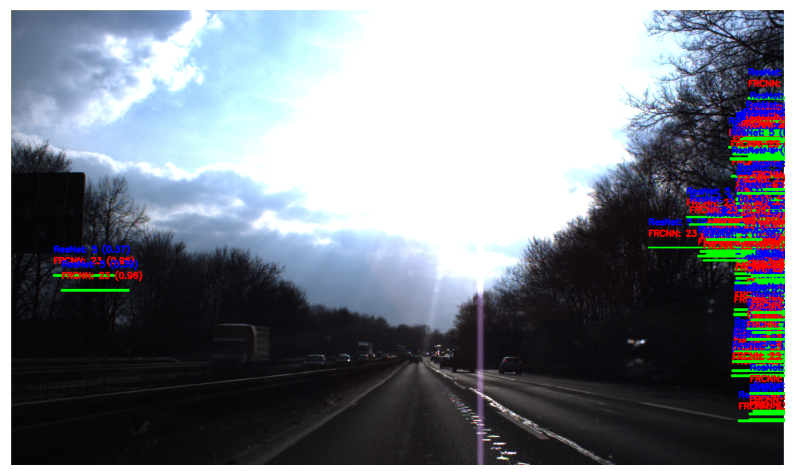

Visualizing predictions for: 00056.ppm


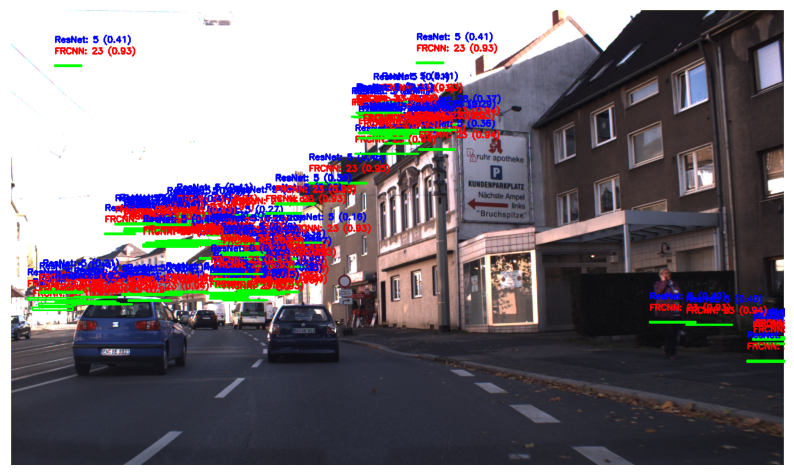

Visualizing predictions for: 00075.ppm


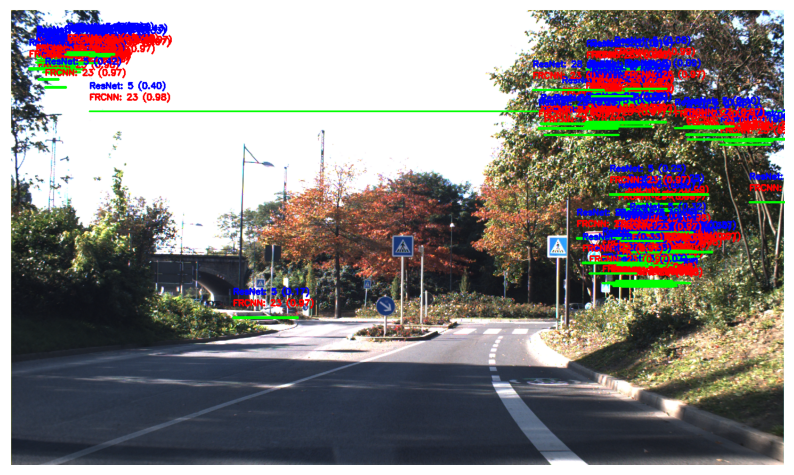

Visualizing predictions for: 00201.ppm


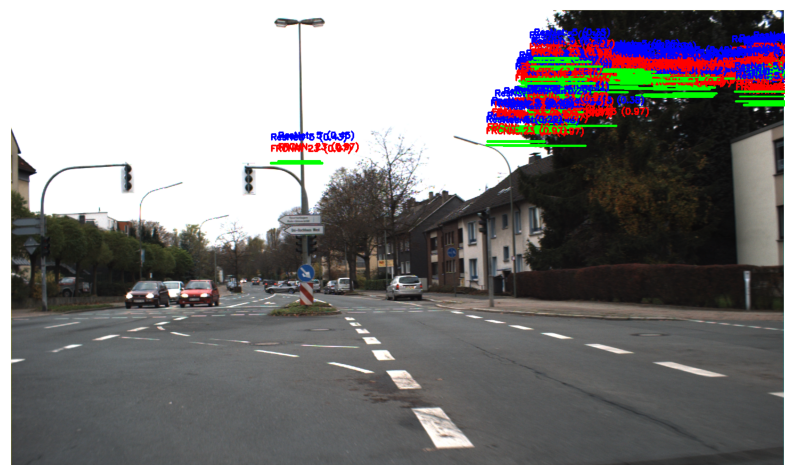

Visualizing predictions for: 00063.ppm


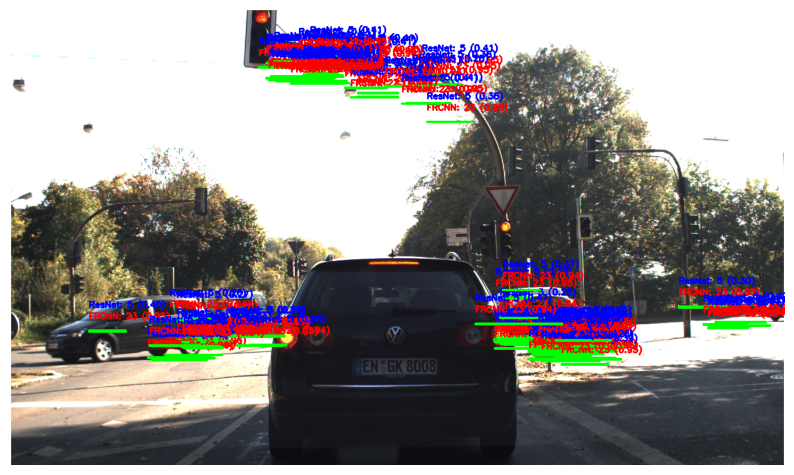

Visualizing predictions for: 00135.ppm


KeyboardInterrupt: 

In [30]:
import os
import numpy as np
# Test images directory
test_images_dir = 'TestIJCNN2013Download'
os.makedirs(test_images_dir, exist_ok=True)

# List all test images
test_images = os.listdir(test_images_dir)

offset = 150
# Visualize predictions for a few images
for i in range(10):  # Visualize first 10 images
    image_path = os.path.join(test_images_dir, test_images[i+offset])
    print(f"Visualizing predictions for: {test_images[i+offset]}")
    visualize_predictions(image_path, model, session, transforms, input_name, output_name)


In [ ]:
import torch
import numpy as np
from tqdm import tqdm
from torchvision.ops import box_iou

def calculate_map(model, dataloader, device, iou_threshold=0.05):
    """
    Υπολογίζει το mAP (Mean Average Precision) για το Faster R-CNN.
    """
    model.eval()
    precisions, recalls = [], []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Evaluating Faster R-CNN"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Προβλέψεις από το Faster R-CNN
            predictions = model(images)

            for img_idx, prediction in enumerate(predictions):
                pred_boxes = prediction["boxes"].cpu()
                pred_scores = prediction["scores"].cpu()
                gt_boxes = targets[img_idx]["boxes"].cpu()

                # Αν δεν υπάρχουν GT boxes, προσπέρασε το frame
                if len(gt_boxes) == 0:
                    print(f"⚠ Warning: No ground truth boxes for image {img_idx}")
                    continue

                if len(pred_boxes) == 0:
                    print(f"⚠ Warning: No predicted boxes for image {img_idx}")
                    continue

                # Υπολογισμός IoU
                ious = box_iou(pred_boxes, gt_boxes)
                max_iou, _ = ious.max(dim=1)

                # Κρατάμε μόνο detections με IoU > threshold
                valid_detections = max_iou > iou_threshold
                tp = valid_detections.sum().item()
                fp = len(pred_boxes) - tp
                fn = max(len(gt_boxes) - tp, 1)  # Βεβαιώσου ότι δεν είναι ποτέ 0

                precision = tp / max(tp + fp, 1e-6)
                recall = tp / (tp + fn)  # FN Ποτέ 0

                precisions.append(precision)
                recalls.append(recall)

                print(f"Image {img_idx}: TP={tp}, FP={fp}, FN={fn}, Precision={precision:.4f}, Recall={recall:.4f}")

    mean_precision = np.mean(precisions)
    mean_recall = np.mean(recalls)
    map_score = mean_precision * mean_recall  # Κανονικοποίηση

    print(f"Precision: {mean_precision:.4f}, Recall: {mean_recall:.4f}, mAP: {map_score:.4f}")

    return map_score

In [ ]:
# Εκτέλεση αξιολόγησης
print("Evaluating Model Performance...")
map_score = calculate_map(model, test_loader, device)

Evaluating Model Performance...


Evaluating Faster R-CNN:   0%|          | 1/426 [00:00<02:24,  2.94it/s]

Image 0: TP=2, FP=0, FN=1, Precision=1.0000, Recall=0.6667
⚠ Warning: No predicted boxes for image 1


Evaluating Faster R-CNN:   0%|          | 2/426 [00:00<02:10,  3.25it/s]

⚠ Warning: No predicted boxes for image 0
⚠ Warning: No predicted boxes for image 1


Evaluating Faster R-CNN:   1%|          | 3/426 [00:00<02:06,  3.35it/s]

⚠ Warning: No predicted boxes for image 0
⚠ Warning: No predicted boxes for image 1


Evaluating Faster R-CNN:   1%|          | 4/426 [00:01<02:04,  3.39it/s]

⚠ Warning: No predicted boxes for image 0
⚠ Warning: No predicted boxes for image 1


Evaluating Faster R-CNN:   1%|          | 5/426 [00:01<02:03,  3.42it/s]

Image 0: TP=0, FP=3, FN=1, Precision=0.0000, Recall=0.0000
Image 1: TP=0, FP=3, FN=1, Precision=0.0000, Recall=0.0000


Evaluating Faster R-CNN:   1%|▏         | 6/426 [00:01<02:01,  3.45it/s]

⚠ Warning: No predicted boxes for image 0
⚠ Warning: No predicted boxes for image 1


Evaluating Faster R-CNN:   2%|▏         | 7/426 [00:02<02:00,  3.47it/s]

Image 0: TP=0, FP=2, FN=1, Precision=0.0000, Recall=0.0000
⚠ Warning: No predicted boxes for image 1


Evaluating Faster R-CNN:   2%|▏         | 8/426 [00:02<02:00,  3.48it/s]

⚠ Warning: No predicted boxes for image 0
⚠ Warning: No predicted boxes for image 1


Evaluating Faster R-CNN:   2%|▏         | 9/426 [00:02<02:00,  3.47it/s]

Image 0: TP=0, FP=2, FN=1, Precision=0.0000, Recall=0.0000
⚠ Warning: No predicted boxes for image 1


Evaluating Faster R-CNN:   2%|▏         | 10/426 [00:02<01:59,  3.47it/s]

⚠ Warning: No predicted boxes for image 0
Image 1: TP=0, FP=1, FN=1, Precision=0.0000, Recall=0.0000


Evaluating Faster R-CNN:   3%|▎         | 11/426 [00:03<01:59,  3.48it/s]

⚠ Warning: No predicted boxes for image 0
⚠ Warning: No predicted boxes for image 1


Evaluating Faster R-CNN:   3%|▎         | 12/426 [00:03<01:59,  3.47it/s]

⚠ Warning: No predicted boxes for image 0
⚠ Warning: No predicted boxes for image 1


Evaluating Faster R-CNN:   3%|▎         | 13/426 [00:03<01:59,  3.44it/s]

⚠ Warning: No predicted boxes for image 0
⚠ Warning: No predicted boxes for image 1


Evaluating Faster R-CNN:   3%|▎         | 14/426 [00:04<01:59,  3.46it/s]

⚠ Warning: No predicted boxes for image 0
⚠ Warning: No predicted boxes for image 1


Evaluating Faster R-CNN:   4%|▎         | 15/426 [00:04<01:59,  3.45it/s]

⚠ Warning: No predicted boxes for image 0
⚠ Warning: No predicted boxes for image 1


Evaluating Faster R-CNN:   4%|▍         | 16/426 [00:04<01:59,  3.42it/s]

⚠ Warning: No predicted boxes for image 0
⚠ Warning: No predicted boxes for image 1


Evaluating Faster R-CNN:   4%|▍         | 17/426 [00:04<01:59,  3.41it/s]

⚠ Warning: No predicted boxes for image 0
⚠ Warning: No predicted boxes for image 1


Evaluating Faster R-CNN:   4%|▍         | 18/426 [00:05<01:59,  3.42it/s]

⚠ Warning: No predicted boxes for image 0
⚠ Warning: No predicted boxes for image 1


Evaluating Faster R-CNN:   4%|▍         | 19/426 [00:05<01:59,  3.41it/s]

⚠ Warning: No predicted boxes for image 0
⚠ Warning: No predicted boxes for image 1


Evaluating Faster R-CNN:   5%|▍         | 20/426 [00:05<01:59,  3.40it/s]

⚠ Warning: No predicted boxes for image 0
Image 1: TP=0, FP=20, FN=1, Precision=0.0000, Recall=0.0000


Evaluating Faster R-CNN:   5%|▍         | 21/426 [00:06<01:59,  3.40it/s]

Image 0: TP=0, FP=20, FN=1, Precision=0.0000, Recall=0.0000
Image 1: TP=0, FP=6, FN=1, Precision=0.0000, Recall=0.0000


Evaluating Faster R-CNN:   5%|▌         | 22/426 [00:06<01:58,  3.40it/s]

Image 0: TP=0, FP=6, FN=1, Precision=0.0000, Recall=0.0000
⚠ Warning: No predicted boxes for image 1


Evaluating Faster R-CNN:   5%|▌         | 22/426 [00:06<02:03,  3.28it/s]


KeyboardInterrupt: 

# Anchors

In [ ]:
# Feature Map's Shape
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

anchor_generator = AnchorGenerator(
    sizes=((16, 32, 64, 128, 256),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)
# 4. Φόρτωση και μετατροπή της εικόνας
image_path = "/content/TrainIJCNN2013/00/00000.ppm"
image = Image.open(image_path).convert("RGB")

image_tensor = transforms(image).unsqueeze(0).to(device)  # Προσθήκη batch dimension

# Φόρτωσε το μοντέλο Faster R-CNN
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.rpn.anchor_generator = anchor_generator  # Προσαρμοσμένος Anchor Generator
model.to(device)  # Μεταφορά μοντέλου στη συσκευή
model.eval()

# Πέρασε την εικόνα από το backbone για να πάρεις τον χάρτη χαρακτηριστικών
with torch.no_grad():
    features = list(model.backbone(image_tensor).values())
for i, feature_map in enumerate(features):
    print(f"Feature map {i} shape: {feature_map.shape}")

Feature map 0 shape: torch.Size([1, 256, 8, 8])
Feature map 1 shape: torch.Size([1, 256, 4, 4])
Feature map 2 shape: torch.Size([1, 256, 2, 2])
Feature map 3 shape: torch.Size([1, 256, 1, 1])
Feature map 4 shape: torch.Size([1, 256, 1, 1])


In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Δημιουργία anchor boxes για ένα συγκεκριμένο feature map
def generate_anchors(scales, ratios, feature_map_size, stride):
    anchors = []
    for i in range(feature_map_size[0]):
        for j in range(feature_map_size[1]):
            center_x = j * stride
            center_y = i * stride
            for scale in scales:
                for ratio in ratios:
                    w = scale * ratio[0]
                    h = scale * ratio[1]
                    anchors.append([center_x, center_y, w, h])
    return torch.tensor(anchors)

# Απεικόνιση anchors σε μία εικόνα
def plot_anchors(image, anchors, feature_map_size, stride):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Μετατροπή συντεταγμένων anchor boxes σε κλίμακα εικόνας
    anchors = anchors.numpy()
    for anchor in anchors:
        center_x, center_y, w, h = anchor
        rect = patches.Rectangle((center_x - w / 2, center_y - h / 2), w, h,
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.title(f"Anchors for feature map {feature_map_size} with stride {stride}")
    plt.show()


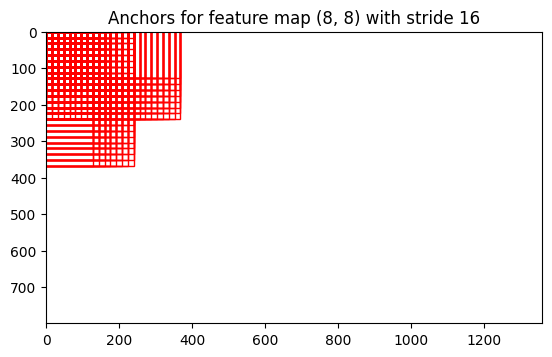

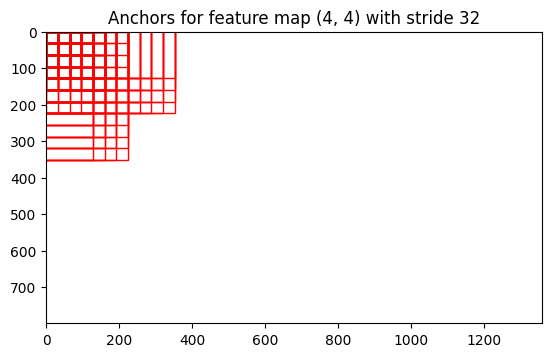

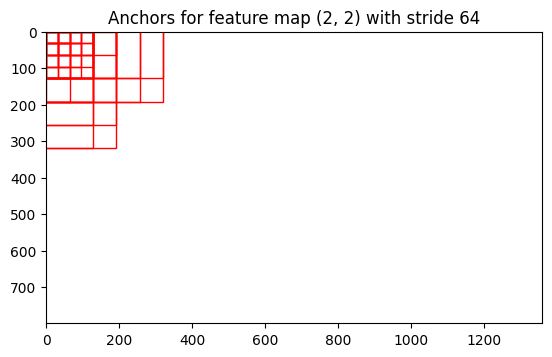

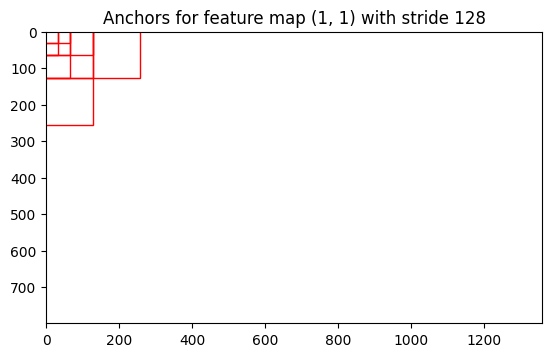

In [ ]:
# Γραφικη απεικονηση των Anchors
image = plt.imread("/content/TrainIJCNN2013/00/00000.ppm")
image = torch.ones((800, 1360, 3))  # Dummy εικόνα (μορφή HxWxC)
scales = [64, 128, 256]  # Κλίμακες των anchors
ratios = [(1, 1), (1, 2), (2, 1)]  # Αναλογίες διαστάσεων
feature_map_sizes = [(8, 8), (4, 4), (2, 2), (1, 1)]  # Διαστάσεις feature maps
strides = [16, 32, 64, 128]  # Stride για κάθε feature map

# Βρόχος για απεικόνιση anchors σε κάθε feature map
for idx, feature_map_size in enumerate(feature_map_sizes):
    stride = strides[idx]
    anchors = generate_anchors(scales, ratios, feature_map_size, stride)
    plot_anchors(image.numpy(), anchors, feature_map_size, stride)


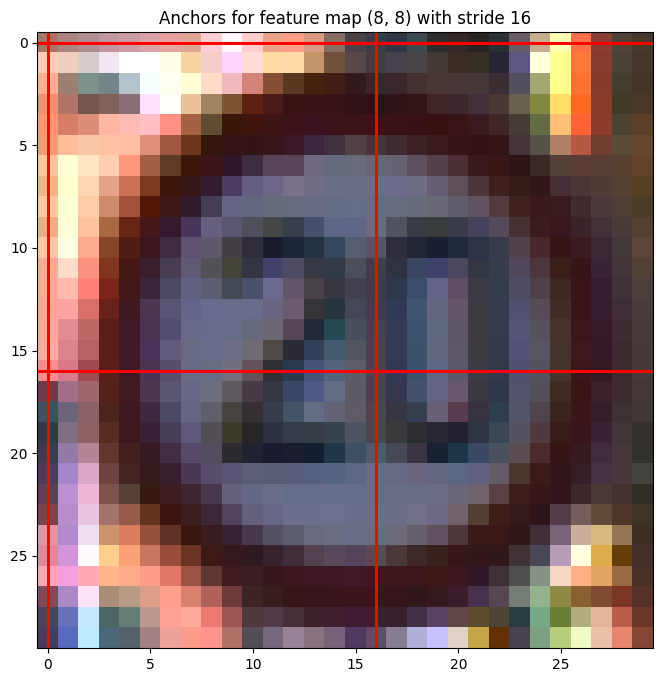

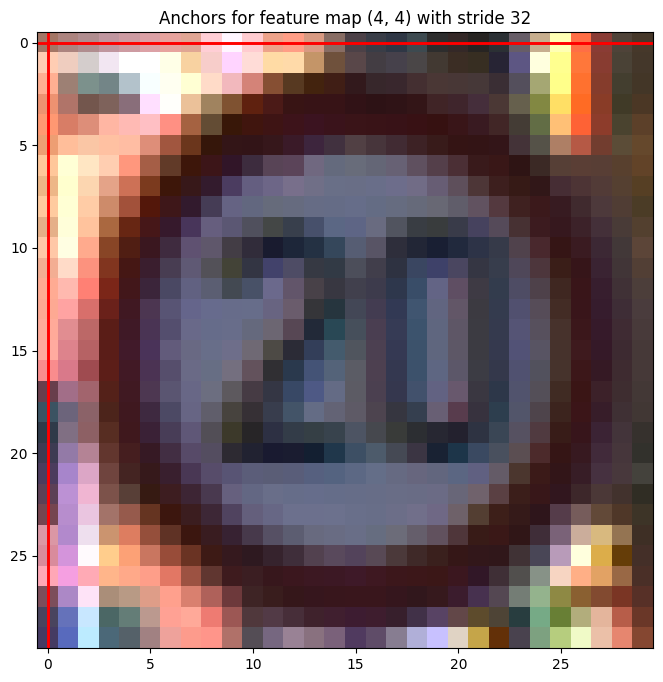

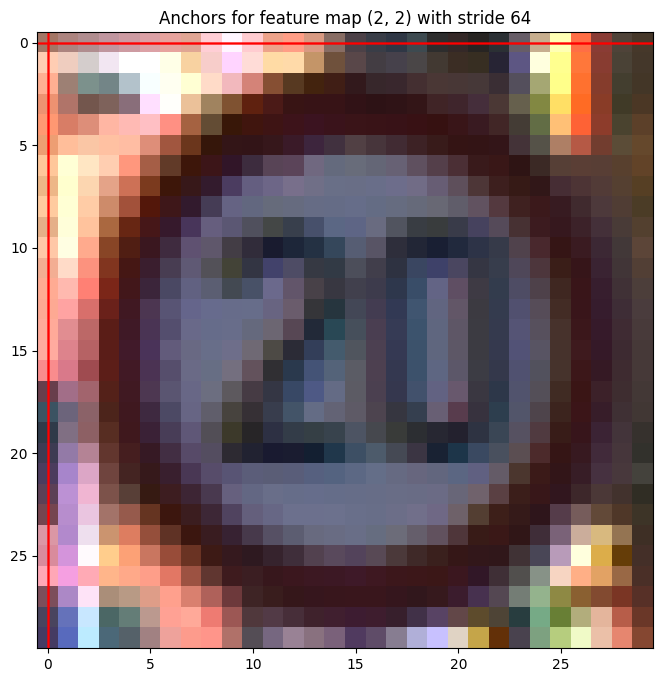

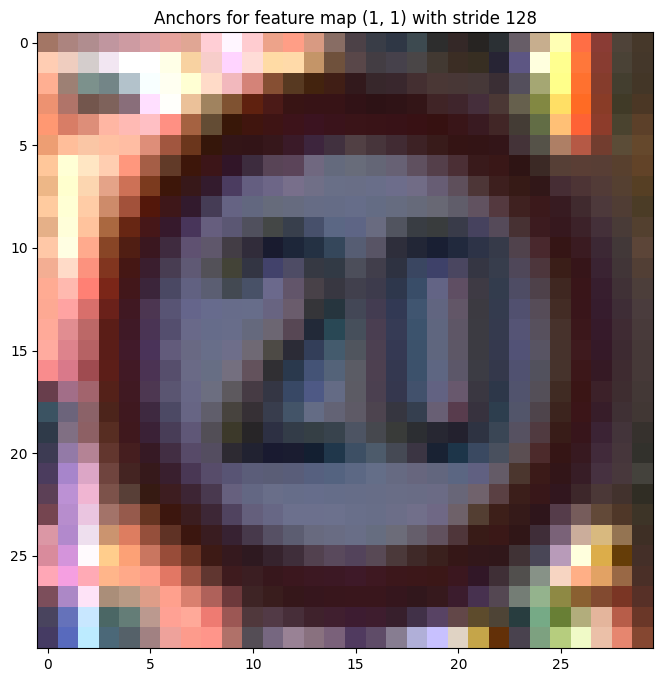

In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Δημιουργία anchor boxes για ένα συγκεκριμένο feature map
def generate_anchors(scales, ratios, feature_map_size, stride):
    anchors = []
    for i in range(feature_map_size[0]):
        for j in range(feature_map_size[1]):
            center_x = j * stride
            center_y = i * stride
            for scale in scales:
                for ratio in ratios:
                    w = scale * ratio[0]
                    h = scale * ratio[1]
                    anchors.append([center_x, center_y, w, h])
    return torch.tensor(anchors)

# Απεικόνιση anchors σε μία εικόνα
def plot_anchors(image, anchors, feature_map_size, stride):
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    # Μετατροπή συντεταγμένων anchor boxes σε κλίμακα εικόνας
    anchors = anchors.numpy()
    for anchor in anchors:
        center_x, center_y, w, h = anchor
        rect = patches.Rectangle((center_x - w / 2, center_y - h / 2), w, h,
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.title(f"Anchors for feature map {feature_map_size} with stride {stride}")
    plt.show()

# Φόρτωση της πραγματικής εικόνας
image_path = "/content/TrainIJCNN2013/00/00000.ppm"
image = plt.imread(image_path)

# Anchor configurations
scales = [64, 128, 256]  # Κλίμακες των anchors
ratios = [(1, 1), (1, 2), (2, 1)]  # Αναλογίες διαστάσεων
feature_map_sizes = [(8, 8), (4, 4), (2, 2), (1, 1)]  # Διαστάσεις feature maps
strides = [16, 32, 64, 128]  # Stride για κάθε feature map

# Βρόχος για απεικόνιση anchors σε κάθε feature map
for idx, feature_map_size in enumerate(feature_map_sizes):
    stride = strides[idx]
    anchors = generate_anchors(scales, ratios, feature_map_size, stride)
    plot_anchors(image, anchors, feature_map_size, stride)
